In [19]:
import numpy as np
from utils import plotting
import umap
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import importlib
importlib.reload(plotting)

burn_in = 0.2

We will first look at the parameter distribution of the symsparse models:

In [ ]:
luad_samples = np.load(
    "../results/mcmc/G13_LUAD_12_symsparse_MALA_0_001421875.npy")
luad_samples = luad_samples[:, int(burn_in * luad_samples.shape[1]):]
luad_samples = luad_samples.reshape(-1, luad_samples.shape[2])

coad_samples = np.load(
    "../results/mcmc/G13_COAD_12_symsparse_MALA_0_001.npy")
coad_samples = coad_samples[:, int(burn_in * coad_samples.shape[1]):]
coad_samples = coad_samples.reshape(-1, coad_samples.shape[2])

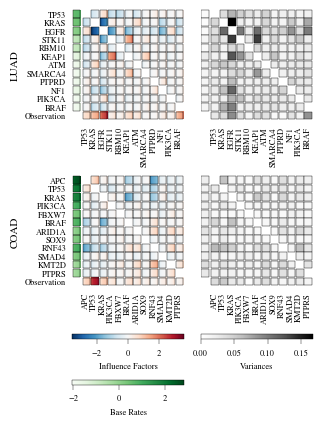

In [ ]:
tile_len = 10

luad_quantiles = np.quantile(luad_samples,
                             np.linspace(0.05, 0.95, tile_len),
                             axis=0).T.reshape(13, -1)
luad_variances = np.var(luad_samples, axis=0).reshape(13, -1)
coad_quantiles = np.quantile(coad_samples,
                             np.linspace(0.05, 0.95, tile_len),
                             axis=0).T.reshape(13, -1)
coad_variances = np.var(coad_samples, axis=0).reshape(13, -1)

n_rows = 2
fig = plt.figure(figsize=(3.21, 2.1 * n_rows + 0.12))
gs = mpl.gridspec.GridSpec(
    n_rows + 2, 2, height_ratios=[1] * n_rows + [0.04, 0.04])

border_len = 0.1
br_ir_sep = 0.2

ax = np.array([[
    fig.add_subplot(gs[j, i])
    for i in range(2)] for j in range(2)])
cbar_ax = np.array([fig.add_subplot(gs[n_rows + i // 2, i % 2])
                   for i in range(3)])

br_min = min(plotting.min_max_br(q, tile_len)[0]
             for q in [luad_quantiles, coad_quantiles])
br_max = max(plotting.min_max_br(q, tile_len)[1]
             for q in [luad_quantiles, coad_quantiles])
max_abs_ir = max(plotting.max_abs_ir(q, tile_len)
                 for q in [luad_quantiles, coad_quantiles])
max_var = max(v.max() for v in [luad_variances, coad_variances])

for i, (data_name, quantiles, variances) in enumerate(
    zip(["G13_LUAD_12", "G13_COAD_12"],
        [luad_quantiles, coad_quantiles],
        [luad_variances, coad_variances])
):

    data = pd.read_csv(f"../data/{data_name}.csv")
    n_events = data.shape[1]
    event_names = data.columns.tolist()

    ax[i, 0].set_ylabel(f"{data_name.split('_')[1]}", fontsize=8)
    plotting.plot_theta_dist(
        quantiles=quantiles,
        tile_len=tile_len,
        n_events=n_events,
        abs_max_ir=max_abs_ir,
        min_br=br_min,
        max_br=br_max,
        events=event_names,
        ax=ax[i, 0])
    plotting.plot_theta_var(
        variances=variances,
        n_events=n_events,
        max_var=max_var,
        events=event_names,
        ax=ax[i, 1])

    ax[i, 0].set_yticks(np.arange(0.5, n_events + 1 +
                                  n_events * border_len, 1 + border_len))
    ax[i, 0].set_yticklabels(
        event_names + ["Observation"], )
    ax[i, 0].tick_params(length=0, pad=4)

    for j in range(2):
        ax[i, j].set_xticks(
            [0.5]
            + (np.arange(1.5, n_events + 1 + n_events *
                         border_len,
                         1 + border_len) + br_ir_sep).tolist())
        ax[i, j].set_xticklabels([""] + event_names, rotation=90)
        ax[i, j].tick_params(length=0, pad=4)

cbars = list()
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=-max_abs_ir, vmax=max_abs_ir), cmap="RdBu_r"),
    cax=cbar_ax[0],
    label="Influence Factors",
    orientation="horizontal",
))
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=0, vmax=max_var), cmap="Greys"),
    cax=cbar_ax[1],
    label="Variances",
    orientation="horizontal",
))
cbars.append(plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(
        vmin=br_min, vmax=br_max), cmap="Greens"),
    cax=cbar_ax[2],
    label="Base Rates",
    orientation="horizontal",
))

for cbar in cbars:
    cbar.outline.set_linewidth(0.3)
    cbar.ax.tick_params(width=0.3)

fig.tight_layout()

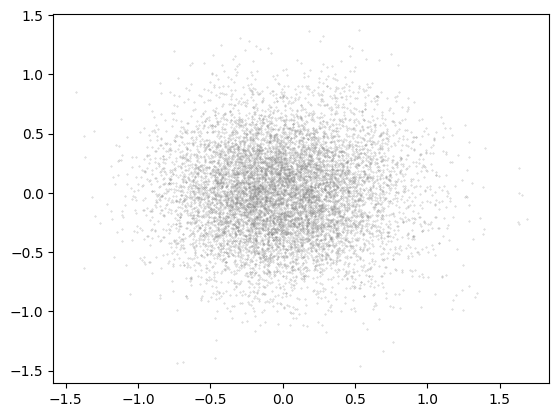

In [23]:
clusterable_embedding = umap.UMAP(
).fit_transform(coad_samples)
labels = HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)
standard_embedding = PCA(n_components=3).fit_transform(coad_samples)
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral')